In [1]:
from mpl_toolkits import mplot3d
from scipy.integrate import ode
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
import pandas as pd
import numpy as np
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Simple model of the early spread of Wuhan virus

This notebook walks through the estimation of the minimum time before transit out of Wuhan must be stopped to prevent an outbreak in another remote city (namely San Francisco).

This is a simplification of the [SIR model](https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-the-differential-equation-model) that only looks in the early time when there's a large population of susceptible people (S) and no one has recovered yet (R).  So this model is really just an "I" model.

Because this model is so simple, I can [non-dimensionalize](https://en.wikipedia.org/wiki/Nondimensionalization) it so it becomes very easy to analyze.  Read [this post]() to see how the model is transformed from 4 free parameters down to a 2 parameter model.

In the next cells, I define the differential equation that underlies the model, and a wrapper function used to get a single simulation run for a set of parameters.

In [2]:
def dy_dt(t, y, rho, tQ):
    """
    dimensionless form of early phase of outbreak model
    computes change in number of infected for two populations, w and c
    rho = initial rate at which infected move from w to c
    tQ = time when the rho is set to 0
    """
    p = rho if t < tQ else 0
    
    # compute dw/dt and dc/dt
    # note that we should have a - p*y[0] term in dw
    # we leave it out because we assume that p<<1
    dw = y[0] - 1
    dc = y[1] - 1 + p*y[0]
    
    # ensure that w, c never become negative
    if dw < 0 and y[0] <= 0:
        dw = 0    
    if dc < 0 and y[1] <= 0:
        dc = 0
    return [dw, dc]

In [3]:
def get_sim(rho,eps,tQ=np.Inf,dt=0.1,t_end=100):
    """
    function for integrating a single simulation run
    """
    # set and store initial conditions
    y0, t0 = [eps+1, 0], 0
    result = [[t0,y0[0],y0[1]]]

    # initialize ode solver
    r = ode(dy_dt).set_integrator('zvode', method='bdf')
    r.set_initial_value(y0, t0).set_f_params(rho,tQ)
    
    # integrate and store results at each dt interval
    while r.successful() and r.t < t_end:
        r.integrate(r.t+dt)
        result.append([r.t,r.y[0],r.y[1]])
    return pd.DataFrame(np.real(result), columns=['t','wuhan','sf'])

### Exponential growth without any quarantine

We can see that in both Wuhan and SF, the growth is exponential.  SF's growth is just delayed. If transit is allowed to continue between the two, then no matter what, eventually the outbreak will spread to SF.

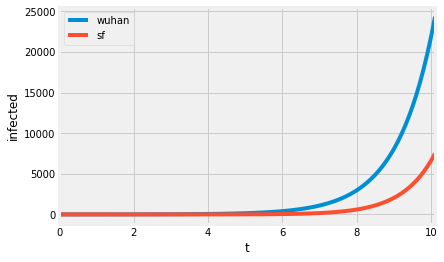

In [4]:
df = get_sim(rho=0.05,eps=1,t_end=10)
df.plot('t',['wuhan','sf'])
hey=plt.ylabel('infected')

### An outbreak can be prevented if transit is cut off

We can set the time at which the transit rate (`rho`) is set to 0.  If this happens early enough we can see that the number of infections in SF can go back to 0.  Here I set the time of quarantine (`tQ`) to 4.45 days, and we can see the number of infected drops back to 0 by day 7.

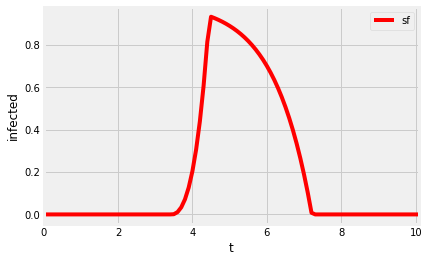

In [5]:
df = get_sim(rho=0.05,eps=0.6,tQ=4.45,t_end=10)
df.plot('t','sf',c='red')
hey=plt.ylabel('infected')

### There's a limited time window for stopping transit to be effective

In this simulation, I kept all the parameters the same, but changed the quarantine time from 4.45 days to 4.5 days.  You can see that it slows the spread down, but the infected population still continues to grow exponentially.

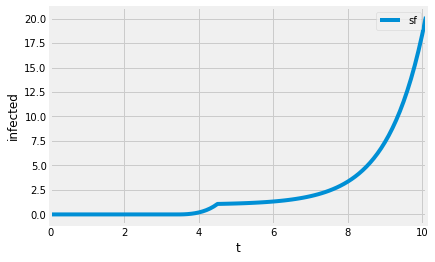

In [6]:
df = get_sim(rho=0.05,eps=0.6,tQ=4.5,t_end=10)
df.plot('t','sf')
hey=plt.ylabel('infected')

But it's mysterious just when we cross over from containable to an unavoidable outbreak.  Why was `tQ`<4.45 OK, while `tQ`=4.5 leads to an epidemic?  

# Estimating the "point of no return" time (`tX`)

Using this model, we can inspect how the "point of no return" (`tX`) depends on the parameters of the model.  This point of no return is composed of two parts, 

- `t+` time when the infection first start to spread in SF
- `tC` the time from t+ to the point where the spread becomes self-sustaining

And `tX = t+ + tC`. To estimate when an outbreak becomes inevitable we need to explore how the free parameters (transit time and starting population) interact to impact both `t+` and `tC`.

### Transit rate `rho` affects the time lag before infection spread in SF

Lowering transit rate (`rho`) delays how long before the SF infection starts to spread.  This makes sense, if we lower the rate of people traveling from Wuhan we would expect to lower the probability of an infection in SF.  In this simulation, I varied rho slightly and that extended the lag before the point where the infected population started increasing in SF.

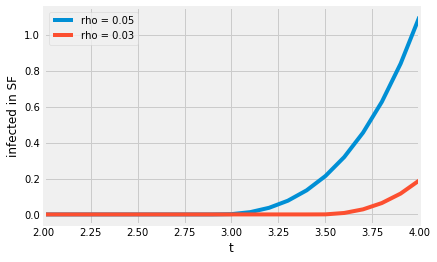

In [7]:
rho = 0.05
df = get_sim(rho=rho,eps=1,t_end=4)
ax = df.plot('t','sf',label=f'rho = {rho}')
rho = 0.03
df = get_sim(rho=rho,eps=1,t_end=4)
df.plot('t','sf',label=f'rho = {rho}',ax=ax)
plt.ylabel('infected in SF')
hey=plt.xlim([2,4])

#### Measuring the effect of transit rate on time to SF infection spread

We define `t+` as the first time when the infected population in SF becomes greater than 0.  We can see how rho affects this time.  In these simulations, I recorded `t+` while varying transit rate (`rho`).

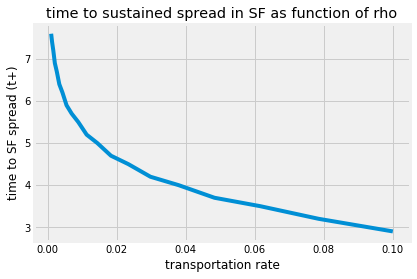

In [8]:
tplus = []
rhos = np.logspace(-3,-1,20)
for rho in rhos:
    df = get_sim(rho,0.5)
    tp = df.loc[df['sf']>0,'t'].iloc[0]
    tplus.append(tp)
plt.plot(rhos,tplus)
# plt.xscale('log')
plt.xlabel('transportation rate')
plt.ylabel('time to SF spread (t+)')
hey=plt.title('time to sustained spread in SF as function of rho')

### Starting population also has an effect  on `t+`

Besides transit rate there is one other parameter to the model, starting infected population in Wuhan.  I've modeled the starting population using a parameter, `eps`, which represents how far the starting population in Wuhan was beyond the minimum outbreak threshold. Because of the non-dimensionalization, the outbreak threshold of this model has been set to 1, so the starting infected population in Wuhan will just be `eps + 1`. Please see [my post]() for a more in depth explanation.

If `eps` is small then the infection will grow more slowly in Wuhan.  This will also mean that it will spread to SF more slowly.

We can plot how both transit rate (`rho`) and starting pop (`eps`) affect `t+`.

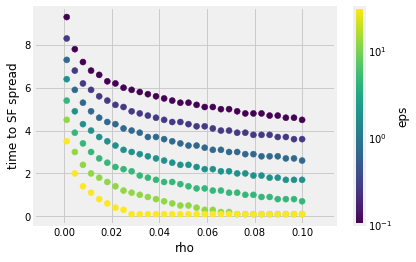

In [9]:
tplus_eps = []
eps = []
rhos = []
for ep in np.logspace(-1,1.5,7):
    for rho in np.linspace(0.001,0.1,30):
        df = get_sim(rho,ep,dt=0.1,t_end=10)
        tp = df.loc[df['sf']>0,'t'].iloc[0]
        eps.append(ep)
        rhos.append(rho)
        tplus_eps.append(tp)
        
plt.scatter(rhos,tplus_eps,c=eps,norm=LogNorm())
plt.xlabel('rho')
plt.ylabel('time to SF spread')
clb = plt.colorbar()
clb.set_label('eps')

#### analytical prediction of `t+`

I was able to work out an analytical estimate of how `t+` should depend on `rho` and `eps`.  Check out [this post](url_here) for the derivation.  My prediction was that 

`t+ = ln(1-rho) - ln(rho) - ln(eps)`

or when that equation is negative, `t+` is just instantaneous.  This turns out to be an exact match with what I measured in the simulations across a wide range of parameters.

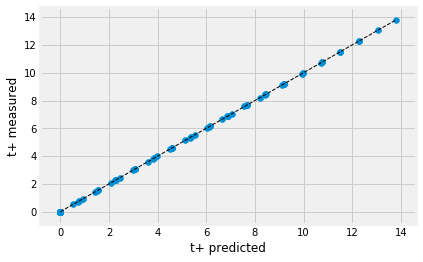

In [10]:
tplus_eps = []
tplus_eps_pred = []
for ep in np.logspace(-3,3,10):
    for rho in np.logspace(-3,0,10):
        df = get_sim(rho,ep,dt=0.01,t_end=20)
        tp = df.loc[df['sf']>0,'t'].iloc[0]
        tp_pred = np.log(1-rho)-np.log(rho)-np.log(ep)
        tp_pred = tp_pred if tp_pred > 0 else 0
        tplus_eps.append(tp)
        tplus_eps_pred.append(tp_pred)
plt.plot([min(tplus_eps_pred),max(tplus_eps_pred)],[min(tplus_eps_pred),max(tplus_eps_pred)],linewidth=1,color='black',linestyle='--')
plt.scatter(tplus_eps_pred, tplus_eps)
plt.xlabel('t+ predicted')
hey=plt.ylabel('t+ measured')

## There's still time after `t+` to stop transit and prevent an outbreak!

It might seem like once the virus reaches SF, then there's no hope. But at least with this model there's still a window to turn.  In the following figure, I ran several simulations while varying `tQ`.  `t+` is marked with a vertical dotted line, but even if transit persists after that point there are scenarios where outbreak is averted. For `tQ` up to 4.95 the number of infected drops back to 0, but once `tQ` hits 5.10 the infected count continues to climb. It looks like the transition point for these parameters happens somewhere around `tQ=5`.

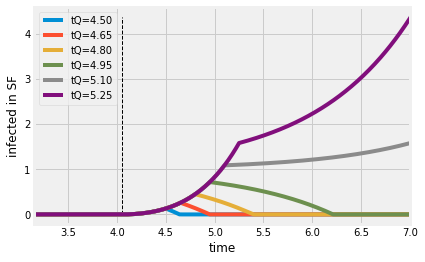

In [11]:
ax = plt.gca()
p = 0.055
e = 0.3
t_end = 7
for tQ in np.linspace(4.5,5.25,6):
    df = get_sim(p,e,dt=0.01,tQ=tQ,t_end=t_end)
    df.plot('t','sf',ax=ax,label=f'tQ={tQ:.2f}')
tplus_pred = np.log(1-p)-np.log(p)-np.log(e)
plt.vlines(tplus_pred,ymin=0,ymax=df['sf'].max(),linestyle='--',linewidth=1)
plt.ylabel('infected in SF')
plt.xlabel('time')
hey=plt.xlim([3.15,t_end])

### `tQ` is the time where the infected in SF reaches 1

I worked through a little math that you can see in [this post](). long story short, if transit is turned off after the infected in SF reaches 1 then the outbreak in SF is self-sustaining (just like in Wuhan).  

Unfortunately, there is no closed form solution for when exactly that time occurs.  However, making [some approximations](), I was able to derive an estimate of this value in the limit where `rho` and `eps` are fairly large.  The approximate amount of time after `t+` before the outbreak is self-sustaining (`tC`) is given by 

`tC = 1/(1-(1-eps)*rho)`

The prediction for `tX` is `tX = t+ + tC`. To see if this makes any sense, I used the following code to show where my prediction was relative to the actual `tX`.  It wasn't too far off.

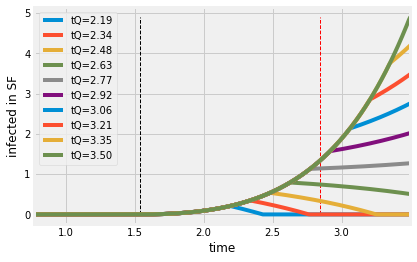

In [12]:
fig = plt.figure()
ax = plt.gca()
p = np.exp(-1)
e = np.exp(-1)
tplus_pred = np.log(1-p)-np.log(p)-np.log(e)
tC_pred = 1/(1-(1-e)*p)
for tQ in np.linspace(tplus_pred+tC_pred/2,tplus_pred+1.5*tC_pred,10):
    df = get_sim(p,e,dt=0.01,tQ=tQ,t_end=tplus_pred+1.5*tC_pred)
    df.plot('t','sf',ax=ax,label=f'tQ={tQ:.2f}')
plt.vlines(tplus_pred,ymin=0,ymax=df['sf'].max(),linestyle='--',linewidth=1)
plt.vlines(tplus_pred+tC_pred,ymin=0,ymax=df['sf'].max(),linestyle='--',linewidth=1,color='red')
plt.ylabel('infected in SF')
plt.xlabel('time')
hey=plt.xlim([tplus_pred/2,tplus_pred+1.5*tC_pred])

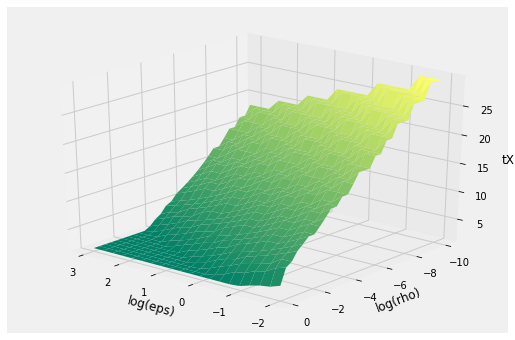

In [13]:
eps = []
rhos = []
tXs = []
tX_preds = []
tplus_preds= []
Y_s = np.logspace(-10,0,30)
X_s = np.logspace(-2,3,20)
for ep in X_s:
    for rho in Y_s:
        tplus_pred = np.log(1-p)-np.log(p)-np.log(e)
        tplus_pred = tplus_pred if tplus_pred > 0 else 0
        tC_pred = 1/(1-(1-e)*p)
        tQ = tplus_pred
        while True:#  for tQ in np.linspace(tplus_pred,10*tplus_pred,5):
            df = get_sim(rho,ep,dt=0.1,tQ=tQ,t_end=tQ+5)
            outbreak = df['sf'].iloc[-1] > 1
            if outbreak:
                tXs.append(tQ)
                break
            tQ = tQ*1.1
        tplus_preds.append(tplus_pred)
        tX_preds.append(tplus_pred+tC_pred)
        eps.append(ep)
        rhos.append(rho)
        if not outbreak:
            tXs.append(None)
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
x2, y2 = np.meshgrid(np.log10(X_s), np.log10(Y_s))
z2 = griddata((np.log10(eps), np.log10(rhos)),tXs, (x2, y2))
surf = ax.plot_surface(x2, y2, z2, cmap=cm.summer)

ax.view_init(25, 130)
ax.set_xlabel('log(eps)')
ax.set_ylabel('log(rho)')
ax.set_zlabel('tX')

plt.show()

# Conclusion

Based on this model, I'd expect there to be a critical outbreak time that's roughly proportional to the logarithm of the transit rate between the two cities.  Now, I would certainly not bet any major public health decisions on this kind of model, but walking through this definitely helped me think more clearly about the problem.  Hopefully, some other curious nerds out there will find this interesting too.  

If you found this interesting and would like to learn more about these methods I strongly suggest Steven Strogatz's [Nonlinear Dynamics and Chaos](https://www.amazon.com/Nonlinear-Dynamics-Chaos-Applications-Nonlinearity/dp/0738204536).  That's where I learned how to think about these kinds of dynamics problems.   

# Appendix: Extending to 3 cities

After working on this for a while, I thought about an interesting variation that might better match what is happening with the Wuhan virus now.  Wuhan was isolated from the US fairly quickly, but there was still a lot of back and forth to other parts of China.  I was wondering how this model would handle 3 locations (Wuhan, rest of China, and SF) where there is only spread from Wuhan -> China and from China -> SF.

Below I implement the diff eq and the simulation wrapper for that case.  As a simplification, I just assume that `rho` is equal for Wuhan -> China and for China -> SF.  That probably isn't the case, but I just wanted to try it.

In [14]:
def dy_dt_3(t, y, rho, tQ):
    """
    dimensionless form of early phase of outbreak model
    computes change in number of infected for two populations, wu and sf
    rho = initial rate at which infected move from wu to sf
    tQ = time when the rho is set to 0
    """
    p = rho if t < tQ else 0
    
    # compute dw/dt and dc/dt
    # note that we should have a - p*y[0] term in dw
    # we leave it out because we assume that p<<1
    dwu = y[0] - 1
    dch = y[1] - 1 + p*y[0]
    dsf = y[2] - 1 + p*y[1]
    
    # ensure that w, c never become negative
    if dwu < 0 and y[0] <= 0:
        dwu = 0    
    if dch < 0 and y[1] <= 0:
        dch = 0    
    if dsf < 0 and y[2] <= 0:
        dsf = 0
    return [dwu, dch, dsf]
def get_sim_3(rho,eps,tQ=np.Inf,dt=0.1,t_end=100):
    """
    function for integrating a single simulation run
    """
    # set and store initial conditions
    y0, t0 = [eps+1, 0,0], 0
    result = [[t0,y0[0],y0[1],y0[2]]]

    # initialize ode solver
    r = ode(dy_dt_3).set_integrator('zvode', method='bdf')
    r.set_initial_value(y0, t0).set_f_params(rho,tQ)
    
    # integrate and store results at each dt interval
    while r.successful() and r.t < t_end:
        r.integrate(r.t+dt)
        result.append([r.t,r.y[0],r.y[1],r.y[2]])
    return pd.DataFrame(np.real(result), columns=['t','wuhan','china','sf'])

We can see how the time to spread in SF (`t+`) is related to the params just like we did before.  I am plotting this with `rho` on a log scale so that it is clear that `t+` depends on the log of both params just like it did before. However, this time the scale is different.

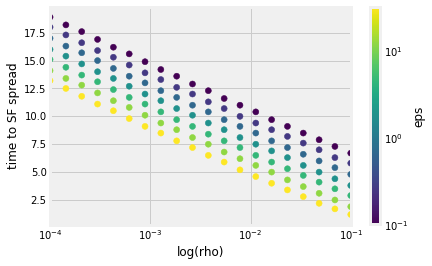

In [15]:
tplus_eps = []
eps = []
rhos = []
for ep in np.logspace(-1,1.5,7):
    for rho in np.logspace(-4,-1,20):
        df = get_sim_3(rho,ep,dt=0.1,t_end=100)
        tp = df.loc[df['sf']>0,'t'].iloc[0]
        eps.append(ep)
        rhos.append(rho)
        tplus_eps.append(tp)
        
plt.scatter(rhos,tplus_eps,c=eps,norm=LogNorm())
plt.xscale('log')
plt.xlim([0.0001,0.1])
plt.xlabel('log(rho)')
plt.ylabel('time to SF spread')
clb = plt.colorbar()
clb.set_label('eps')

This led me to suspect that we can basically just take `rho^2` to be the effective transit rate from Wuhan to SF.  This sort of makes sense because now we are just looking at the product of the probability of transfer Wuhan->China and that of China->SF.

I tested it out by comparing the measurement to the formula

`t+ = ln(1-rho*rho)-ln(rho*rho)-ln(eps)`

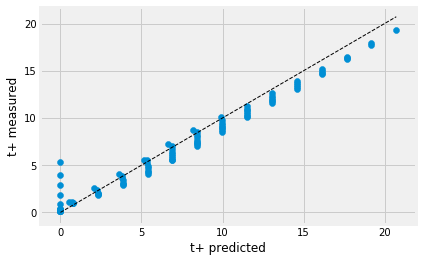

In [16]:
tplus_eps = []
tplus_eps_pred = []
for ep in np.logspace(-3,3,10):
    for rho in np.logspace(-3,0,10):
        df = get_sim_3(rho,ep,dt=0.1,t_end=20)
        tp = df.loc[df['sf']>0,'t'].iloc[0]
        tp_pred = np.log(1-rho*rho)-np.log(rho*rho)-np.log(ep)
        tp_pred = tp_pred if tp_pred > 0 else 0
        tplus_eps.append(tp)
        tplus_eps_pred.append(tp_pred)
plt.plot([min(tplus_eps_pred),max(tplus_eps_pred)],[min(tplus_eps_pred),max(tplus_eps_pred)],linewidth=1,color='black',linestyle='--')
plt.scatter(tplus_eps_pred, tplus_eps)
plt.xlabel('t+ predicted')
hey=plt.ylabel('t+ measured')

### Spreading through two cities just doubles the time to the point of no return

If we're effectively just squaring the constant `rho` to get the effective transit rate for two cities, this should have a simple effect on the time of the point of no return `tX`.  We would expect for the same values of `rho` and `eps`, we'd just need to double `tX`.  We can check how the 3 location model compares to the 2 location model directly.

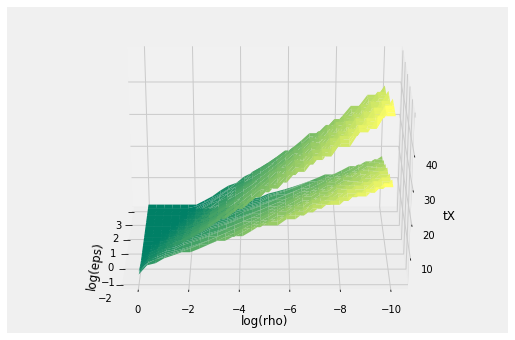

In [17]:
eps = []
rhos = []
tXs = []
tX_preds = []
tplus_preds= []
for ep in X_s:
    for rho in Y_s:
        tplus_pred = np.log(1-p*p)-np.log(p*p)-np.log(e)
        tplus_pred = tplus_pred if tplus_pred > 0 else 0
        tC_pred = 1/(1-(1-e)*p)
        tQ = tplus_pred
        while True:#  for tQ in np.linspace(tplus_pred,10*tplus_pred,5):
            df = get_sim_3(rho,ep,dt=1,tQ=tQ,t_end=tQ+5)
            outbreak = df['sf'].iloc[-1] > 1
            if outbreak:
                tXs.append(tQ)
                break
            tQ = tQ*1.1
        tplus_preds.append(tplus_pred)
        tX_preds.append(tplus_pred+tC_pred)
        eps.append(ep)
        rhos.append(rho)
        if not outbreak:
            tXs.append(None)
        
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
x3, y3 = np.meshgrid(np.log10(X_s), np.log10(Y_s))
z3 = griddata((np.log10(eps), np.log10(rhos)),tXs, (x3, y3))
surf = ax.plot_surface(x2, y2, z2, cmap=cm.summer)
surf = ax.plot_surface(x3, y3, z3, cmap=cm.summer)

ax.view_init(25, 180)
ax.set_xlabel('log(eps)')
ax.set_ylabel('log(rho)')
ax.set_zlabel('tX')

plt.show()

Indeed it looks like adding another city just roughly doubles the time to the point of no return for the same `rho` and `eps`.  So I guess it's good that Wuhan was less of a major transportation hub to the US than Beijing, Shanghai, or Hong Kong.

That's about all I have time for This last model would get much more interesting if `rho` and `tQ` could could vary between the different cities.  But that's a project for another time.